In [1]:
import os
from src.config import ROOT_DIR, RESULTS
from src.calculate_AF_by_cell import calculate_af
import yaml 
import pandas as pd
from os.path import join
import seaborn as sns
import pickle
import glob
os.chdir(ROOT_DIR)
with open('parameters/2020_09_07_Croker_mito.yaml') as f:
    config = yaml.safe_load(f)
samples = pd.read_table(config["samples"], dtype=str,sep=',').set_index(["sample"], drop=False)
samples

Project Directory: /data2/mito_lineage


,sample,raw,bam,bam_f
sample,,,,
CD34_Flt3L_mt_PolydT,CD34_Flt3L_mt_PolydT,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
CD34_Flt3L_PolydT,CD34_Flt3L_PolydT,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
CD34_Flt3L_mt,CD34_Flt3L_mt,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
CD34_mt_PolydT,CD34_mt_PolydT,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
CD34_mt,CD34_mt,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
CD34_PolydT,CD34_PolydT,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
PBMC_mt,PBMC_mt,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...
PBMC_mt_PolydT,PBMC_mt_PolydT,NaN,NaN,/data2/isshamie/mito_lineage/data/processed/20...


In [2]:
min_cells=10
min_reads=10
topN=0
min_het_cells=10
het_thresh=0.1

f_name = f"minC{min_cells}_minReads{min_reads}_topC{topN}_hetC{min_het_cells}_hetT{het_thresh}_mapq30"
print(f_name)

minC10_minReads10_topC0_hetC10_hetT0.1_mapq30


In [3]:
from numpanpar import parallel_df as pardf

In [4]:
indir=join(RESULTS,"mttrace")

dirname = f"minC{min_cells}_minR{min_reads}_topN{topN}_hetC{min_het_cells}_hetT{het_thresh}"
outdir = join(indir, "lineage_trace/CD34_mt_polydT/report", dirname)
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/data2/mito_lineage/data/processed/mttrace/lineage_trace/CD34_mt_polydT/report/minC10_minR10_topN0_hetC10_hetT0.1'

In [5]:
samples_af_by_cell = {}
samples_af = {}
maxBP = 16571
for ind, val in samples.iterrows():
    coverage_dir = join('data/processed/mttrace/',ind,'mapq_30', ind+ '_scPileup_200')
    concat_dir = join('data/processed/mttrace/',ind, 'mapq_30','scPileup_concat_200')
    if 'mt_PolydT' in ind:
        print(ind)
        AF_by_cell, _, af, _, _ = calculate_af(coverage_dir, concat_dir, ref_fasta=config['ref_fa'],                                               
                                                                AF_F=None, maxBP=maxBP, topN=topN, 
                                                                min_cells=min_cells, min_reads=min_reads,
                                                                min_het_cells=min_het_cells, het_thresh=het_thresh)
        samples_af[ind] = af
        samples_af_by_cell[ind] = AF_by_cell

CD34_Flt3L_mt_PolydT
no alt count 2142
topN 0
Number of positions to keep : 4130
Number of cells to keep : 2777
Positions that pass het filter: 1937
CD34_mt_PolydT
no alt count 5331
topN 0
Number of positions to keep : 1758
Number of cells to keep : 887
Positions that pass het filter: 157
PBMC_mt_PolydT
no alt count 10431
topN 0
Number of positions to keep : 1491
Number of cells to keep : 212
Positions that pass het filter: 32


In [7]:
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [9]:
pickle.dump([samples_af, samples_af_by_cell], open(join(outdir, 'af_merge.p'),'wb'))

### Calculate Heteroplasmy pairplot

In [10]:
samples_af_cov = {}
for ind in samples_af:
    samples_af_cov[ind] = samples_af[ind]['AF']

samples_af_cov_df = pd.DataFrame(samples_af_cov)

In [11]:
samples_af_cov_df

,CD34_Flt3L_mt_PolydT,CD34_mt_PolydT,PBMC_mt_PolydT
3,0.00303951,NaN,NaN
9,0.00508906,NaN,NaN
10,NaN,0.0166667,NaN
11,0.00249377,NaN,NaN
17,0.00692841,0.0140845,NaN
...,...,...,...
16551,0.0151515,NaN,NaN
16552,0.0153846,NaN,NaN
16555,0.015873,NaN,NaN
16564,0.0701754,NaN,NaN


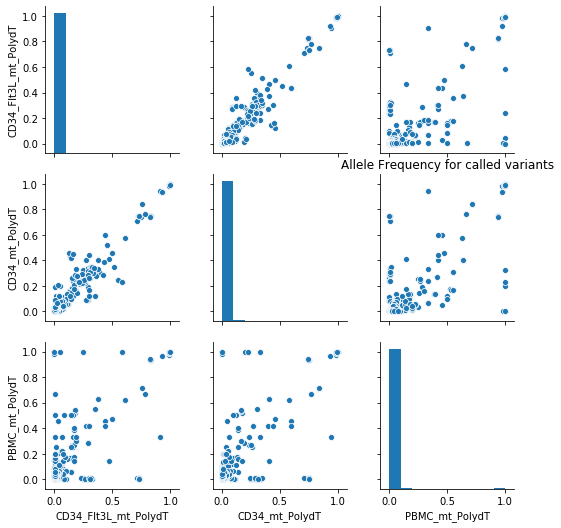

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.pairplot(samples_af_cov_df)
plt.title("Allele Frequency for called variants")
plt.savefig(join(outdir, 'het_across_all_samples'))

### Add other samples

In [15]:
samples_af_by_cell = {}
samples_af = {}
maxBP = 16571
for ind, val in samples.iterrows():
    coverage_dir = join('data/processed/mttrace/',ind,'mapq_30', ind+ '_scPileup_200')
    concat_dir = join('data/processed/mttrace/',ind, 'mapq_30','scPileup_concat_200')
    if not 'mt_PolydT' in ind:
        print(ind)
        AF_by_cell, _, af, _, _ = calculate_af(coverage_dir, concat_dir, ref_fasta=config['ref_fa'],                                               
                                                                AF_F=None, maxBP=maxBP, topN=topN, 
                                                                min_cells=min_cells, min_reads=min_reads,
                                                                min_het_cells=min_het_cells, het_thresh=het_thresh)
        samples_af[ind] = af
        samples_af_by_cell[ind] = AF_by_cell

CD34_Flt3L_PolydT
no alt count 1066
topN 0
Number of positions to keep : 6999
Number of cells to keep : 7384
Positions that pass het filter: 5834
CD34_Flt3L_mt
no alt count 5449
topN 0
Number of positions to keep : 3193
Number of cells to keep : 1214
Positions that pass het filter: 375
CD34_mt
no alt count 11481
topN 0
Number of positions to keep : 2227
Number of cells to keep : 218
Positions that pass het filter: 49
CD34_PolydT
no alt count 14347
topN 0
Number of positions to keep : 948
Number of cells to keep : 65
Positions that pass het filter: 10
PBMC_mt
no alt count 13132
topN 0
Number of positions to keep : 1926
Number of cells to keep : 202
Positions that pass het filter: 31


In [ ]:
samples_af_by_cell

In [ ]:
def plot_top_hets(af_by_cell, hets, sample_col=None, f_save=None):
    f, ax = plt.subplots(nrows=len(hets))
    for ind, h in enumerate(hets):
        sns.violinplot(af_by_cell[h], hue=sample_col, inner = "stick", ax=ax[ind])
    helper_save(f_save)
    return